In [2]:
%load_ext autoreload
%autoreload 2

# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage
from scipy import stats
from scipy.ndimage import gaussian_filter 
from sklearn.neighbors import KernelDensity
import seaborn as sns
import plotly.graph_objects as go

In [1]:
season_year = 2017
season_type = "Regular"

In [3]:
import src.data.NHLDataManager as DataManager
data_manager = DataManager.NHLDataManager()

In [410]:
game_numbers = data_manager.get_game_numbers(season_year=season_year, season_type=season_type)
data_season_df = data_manager.get_goals_and_shots_df(season_year=season_year, season_type=season_type, game_number=game_numbers[0])

for game_number in game_numbers[1:]:
    data_season_df = pd.concat([data_season_df, data_manager.get_goals_and_shots_df(season_year=season_year, season_type=season_type, game_number=game_number)], ignore_index=True)

In [5]:
data_season_df.to_json(os.path.join(data_manager.data_dir, str(season_year), season_type, f"data_season_df_{season_year}_{season_type}.json"))
print(data_season_df.sample(10))

          Game ID Event Index   Time Period                         Team  \
51072  2017020795         103  03:10      2         Buffalo Sabres (BUF)   
53686  2017020836         118  17:01      1       New York Rangers (NYR)   
22687  2017020353         222  16:13      2    Pittsburgh Penguins (PIT)   
2785   2017020042          43  08:15      1    Nashville Predators (NSH)   
38012  2017020593         279  14:15      3   Vegas Golden Knights (VGK)   
10504  2017020162         219  00:38      3  Columbus Blue Jackets (CBJ)   
14541  2017020225         279  15:41      3     New York Islanders (NYI)   
64389  2017020999         131  02:42      2          Anaheim Ducks (ANA)   
48802  2017020760         168  17:09      2       New York Rangers (NYR)   
74963  2017021163           4  00:26      1    Philadelphia Flyers (PHI)   

       Type   Shot Type        Shooter             Goalie Empty Net  \
51072  SHOT   Snap Shot    Kyle Okposo      Carter Hutton       NaN   
53686  SHOT   Snap Sh

In [6]:
total_shots_league = len(data_season_df)
number_of_games = len(data_season_df['Game ID'].unique())
print(f'Total number of shots during season {season_year} ({season_type}) = {total_shots_league}')
print(f'Number of games during season {season_year} ({season_type}) = {number_of_games}')

mean_shots_per_hour = total_shots_league / number_of_games
print(f'Mean shots per hour during season {season_year} ({season_type}) = {mean_shots_per_hour}')

total_goals_league = len(data_season_df[data_season_df['Type'] == 'GOAL'])
mean_goals_per_hour = total_goals_league / number_of_games
print(f'Mean goals per hour during season {season_year} ({season_type}) = {mean_goals_per_hour}')


Total number of shots during season 2017 (Regular) = 81873
Number of games during season 2017 (Regular) = 1271
Mean shots per hour during season 2017 (Regular) = 64.4162077104642
Mean goals per hour during season 2017 (Regular) = 6.051140833988985


In [7]:
list_of_teams = data_season_df['Team'].unique()
number_of_teams = len(list_of_teams)

print(f'Number of Teams during season {season_year} ({season_type}) = {number_of_teams}')

Number of Teams during season 2017 (Regular) = 31


In [8]:
number_of_games_by_team = int(2 * len(data_season_df['Game ID'].unique()) / len(data_season_df['Team'].unique()))
assert(number_of_games_by_team == 82)

In [9]:
data_season_df[['Team', 'Type', 'X', 'Y', 'Period', 'Game ID']].head(15)

,Team,Type,X,Y,Period,Game ID
0,Toronto Maple Leafs (TOR),GOAL,84.0,-6.0,1,2017020001
1,Toronto Maple Leafs (TOR),GOAL,62.0,5.0,1,2017020001
2,Toronto Maple Leafs (TOR),GOAL,84.0,-22.0,1,2017020001
3,Toronto Maple Leafs (TOR),GOAL,-82.0,2.0,2,2017020001
4,Toronto Maple Leafs (TOR),GOAL,68.0,12.0,3,2017020001
5,Toronto Maple Leafs (TOR),GOAL,85.0,-6.0,3,2017020001
6,Winnipeg Jets (WPG),GOAL,-82.0,8.0,3,2017020001
7,Toronto Maple Leafs (TOR),GOAL,84.0,-3.0,3,2017020001
8,Winnipeg Jets (WPG),GOAL,-80.0,1.0,3,2017020001
9,Winnipeg Jets (WPG),SHOT,-36.0,-28.0,1,2017020001


In [10]:
df_total_shots_season_by_team = data_season_df[['Team', 'Type', 'X', 'Y']].dropna().groupby('Team').size()
df_total_shots_season_by_team.sample(20)

Team
Chicago Blackhawks (CHI)     2805
San Jose Sharks (SJS)        2736
Dallas Stars (DAL)           2579
New York Rangers (NYR)       2562
Toronto Maple Leafs (TOR)    2674
Carolina Hurricanes (CAR)    2796
Montréal Canadiens (MTL)     2710
Minnesota Wild (MIN)         2501
Edmonton Oilers (EDM)        2756
Washington Capitals (WSH)    2388
Philadelphia Flyers (PHI)    2664
New Jersey Devils (NJD)      2628
Vancouver Canucks (VAN)      2486
Arizona Coyotes (ARI)        2472
Buffalo Sabres (BUF)         2565
Los Angeles Kings (LAK)      2553
Ottawa Senators (OTT)        2542
Anaheim Ducks (ANA)          2514
Detroit Red Wings (DET)      2517
Pittsburgh Penguins (PIT)    2832
dtype: int64

In [11]:
df_mean_shots_per_team_by_hour = df_total_shots_season_by_team / number_of_games_by_team
print(df_mean_shots_per_team_by_hour.sample(10))

Team
Edmonton Oilers (EDM)        33.609756
Tampa Bay Lightning (TBL)    32.878049
New York Islanders (NYI)     31.548780
Buffalo Sabres (BUF)         31.280488
Minnesota Wild (MIN)         30.500000
Ottawa Senators (OTT)        31.000000
Montréal Canadiens (MTL)     33.048780
Winnipeg Jets (WPG)          32.475610
Carolina Hurricanes (CAR)    34.097561
Toronto Maple Leafs (TOR)    32.609756
dtype: float64


In [12]:
def convert_shots_to_offensize_zone(x_shots, y_shots):

   # Shots taken from behind the goal is from the defensive zone.
   # Since we are only interested in shots taken in the offensive zone, we skip them
   shots_defzone_mask = (x_shots < -89) | (x_shots > 89)
   x_shots = x_shots[~shots_defzone_mask] 
   y_shots = y_shots[~shots_defzone_mask]

   # Flip the y coordinates if x is negative
   shots_xneg_mask = x_shots < 0
   x_shots = abs(x_shots)
   y_shots[shots_xneg_mask] = -y_shots[shots_xneg_mask] 

   # Reverse the x axis, so the goal is at 0
   x_shots = 89 - x_shots

   return [x_shots, y_shots]

In [13]:
x_shots_season = data_season_df['X'].dropna().to_numpy().copy().astype(np.float32)
y_shots_season = data_season_df['Y'].dropna().to_numpy().copy().astype(np.float32)

[x_shots_season, y_shots_season] = convert_shots_to_offensize_zone(x_shots_season, y_shots_season)

number_of_games = len(data_season_df['Game ID'].unique())
print(number_of_games)

#print(x_shots_season.__len__())

1271


In [270]:
# data_one_team_df = data_season_df.loc[data_season_df['Team'] == "Buffalo Sabres (BUF)"]
data_one_team_df = data_season_df.loc[data_season_df['Team'] == "Tampa Bay Lightning (TBL)"]


df_total_shots_one_team = data_one_team_df[['Team', 'Type', 'X', 'Y']].dropna()

x_shots_one_team = df_total_shots_one_team['X'].dropna().to_numpy().copy().astype(np.float32)
y_shots_one_team = df_total_shots_one_team['Y'].dropna().to_numpy().copy().astype(np.float32)

[x_shots_one_team, y_shots_one_team] = convert_shots_to_offensize_zone(x_shots_one_team, y_shots_one_team)


In [417]:
def get_shots_hist2D(x_shots, y_shots, num_pts_x=20, num_pts_y=20):

    x_min, x_max = 0.0, 89.0
    y_min, y_max = -42.5, 42.5

    x_grid = np.linspace(x_min, x_max, num_pts_x+1)
    y_grid = np.linspace(y_min, y_max, num_pts_y+1)

    ret = stats.binned_statistic_2d(x_shots.tolist(), y_shots.tolist(), None, 'count', bins=[x_grid.tolist(), y_grid.tolist()])

    x_bins = (0.5 * (x_grid[1:] + x_grid[0:-1]))
    y_bins = (0.5 * (y_grid[1:] + y_grid[0:-1]))

    return  ret.statistic, x_bins, y_bins


0.4878048780487805


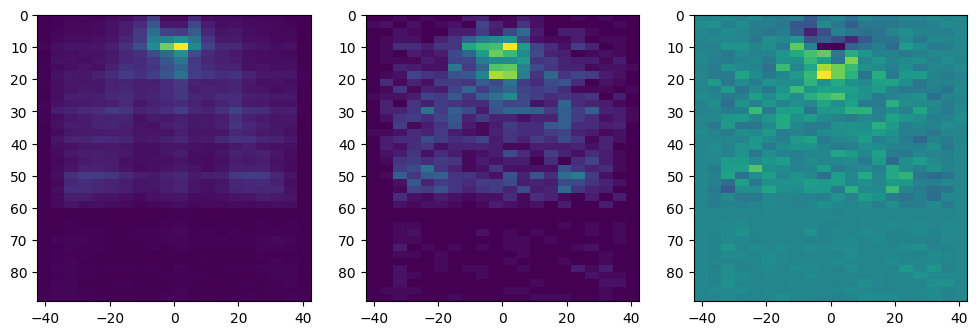

In [418]:
shots_hist2D_season, _, _ = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=40, num_pts_y=20)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)

shots_hist2D_one_team, _, _ = get_shots_hist2D(x_shots_one_team, y_shots_one_team, num_pts_x=40, num_pts_y=20)
shots_hist2D_one_team_by_hour = shots_hist2D_one_team / number_of_games_by_team


fig, ax = plt.subplots(1, 3, figsize=(12,12))

ax[0].imshow(shots_hist2D_season_by_hour, extent=[-42.5, 42.5, 89, 0])
ax[1].imshow(shots_hist2D_one_team_by_hour, extent=[-42.5, 42.5, 89, 0])
ax[2].imshow(shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour, extent=[-42.5, 42.5, 89, 0])

print(shots_hist2D_one_team_by_hour.max())
plt.show()


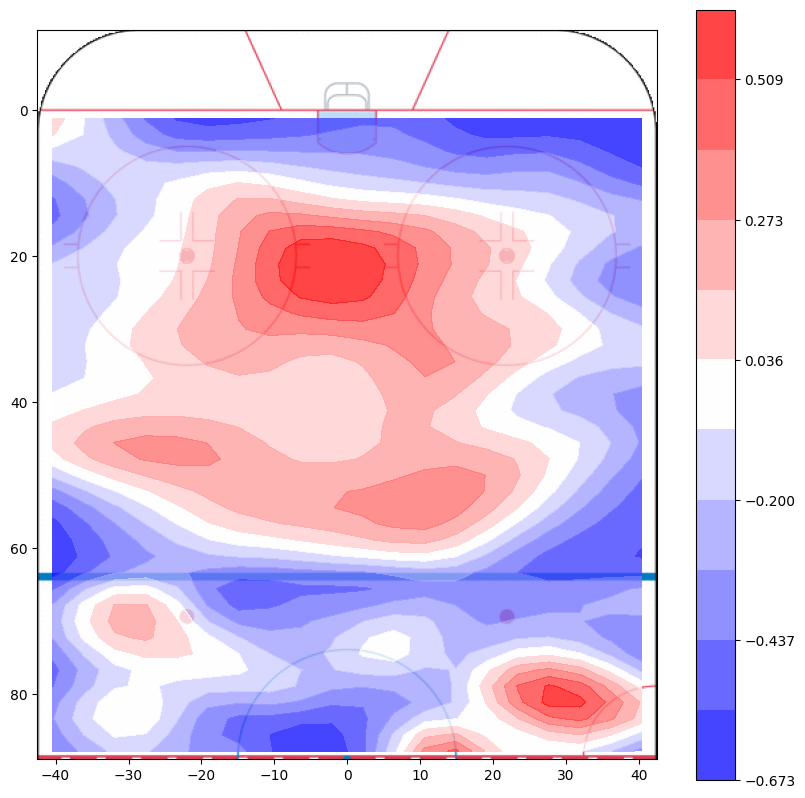

In [419]:
shots_hist2D_season, x_grid, y_grid = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=40, num_pts_y=20)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)

shots_hist2D_one_team, x_grid, y_grid = get_shots_hist2D(x_shots_one_team, y_shots_one_team, num_pts_x=40, num_pts_y=20)
shots_hist2D_one_team_by_hour = shots_hist2D_one_team / (number_of_games_by_team)

shots_hist2D_season_by_hour_s = gaussian_filter(shots_hist2D_season_by_hour, sigma = 1.5)
shots_hist2D_one_team_by_hour_s = gaussian_filter(shots_hist2D_one_team_by_hour, sigma = 1.5)

diff = (shots_hist2D_one_team_by_hour_s-shots_hist2D_season_by_hour_s) / shots_hist2D_season_by_hour_s

# Not necessary
diff_min = diff.min()
diff_max = diff.max()
alpha = (-2./(diff_min-diff_max)) 
beta = (diff_min + diff_max) / (diff_min - diff_max)
diff_norm = alpha * diff + beta

rink_img = (255 * mpimg.imread("./figures/nhl_rink.png")).astype(int)
(h, w, c) = rink_img.shape
rink_half_img = rink_img[:, int(w/2):, :]
rink_half_img = ndimage.rotate(rink_half_img, 90).astype(int)

fig = plt.figure(figsize=(10,10))
plt.contourf(y_grid, x_grid, diff, alpha=0.8, cmap='bwr', levels = np.linspace(diff.min(), diff.max(), 12), vmin=diff.min(), vmax=diff.max())
plt.colorbar(orientation = 'vertical')
plt.imshow(rink_half_img, extent=[-42.5, 42.5, 89, -11])

# plt.contourf(y_grid, x_grid, diff_norm, alpha=0.8, cmap='bwr', levels = np.linspace(-1, 1, 20))





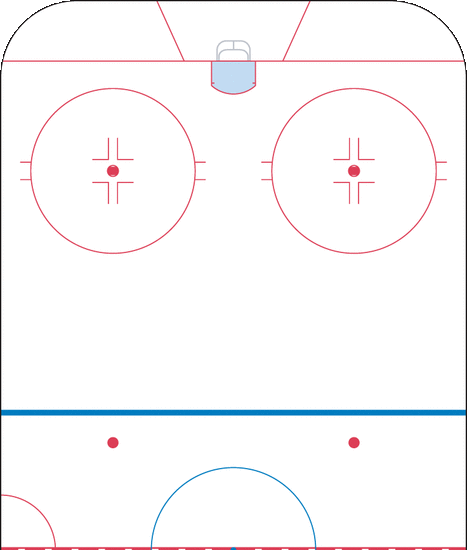

In [420]:
import plotly.graph_objects as go
import plotly.express as px

import pandas as pd
from PIL import Image

# load dataset

# Create figure
fig = go.Figure()

rink_img = Image.open("./figures/nhl_rink.png")
width, height = rink_img.size
rink_half_img = rink_img.crop((0, 0, width/2, height))
rink_half_img = rink_half_img.rotate(270, expand=1)

# Constants
img_width = 800
img_height = 1600/2
scale_factor = 1.0


fig.add_trace(
    go.Heatmap(
        z=diff.tolist(),
        x=y_grid,
        y=x_grid,
        colorscale="Rdbu", 
        reversescale=True,
        connectgaps=True,
        zsmooth='best',
        opacity=0.5
    )
)

fig.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

fig.update_xaxes(
    # visible=True,
    showgrid=False,
    range=[-42.5, 42.5])

fig.update_yaxes(
    # visible=True,
    # showgrid=False,
    # autorange="reversed",
    range=[89, -11])

fig.add_layout_image(
    dict(
        x=-42.5,
        sizex=42.5*2,
        y=-11,
        sizey=100,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=rink_half_img)
)


fig.show()

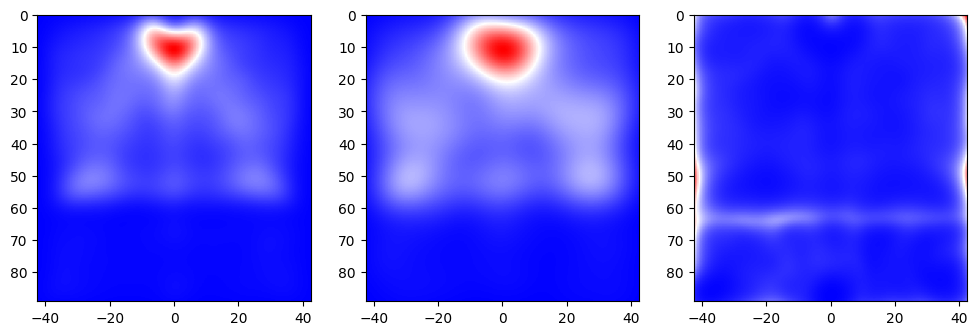

In [206]:
x_min, x_max = 0, 89
y_min, y_max = -42.5, 42.5


def get_kde(x_shots, y_shots):

   X, Y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
   positions = np.vstack([X.ravel(), Y.ravel()])
   values = np.vstack([x_shots, y_shots])
   kernel = stats.gaussian_kde(values)
   Z = np.reshape(kernel(positions).T, X.shape)

   # Z = Z / Z.max()

   return Z

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

kde_season = get_kde(x_shots_season, y_shots_season)
ax[0].imshow(kde_season, cmap='bwr', extent=[y_min, y_max, x_max, x_min])
# ax[0].plot(y_shots_season, x_shots_season, 'k.', markersize=2)
ax[0].set_xlim([y_min, y_max])
ax[0].set_ylim([x_max, x_min])

kde_team = get_kde(x_shots_one_team, y_shots_one_team)
ax[1].imshow(kde_team, cmap='bwr', extent=[y_min, y_max, x_max, x_min])
# ax[1].plot(y_shots_one_team, x_shots_one_team, 'k.', markersize=2)
ax[1].set_xlim([y_min, y_max])
ax[1].set_ylim([x_max, x_min])

kde_diff = (kde_team - kde_season) / kde_season
ax[2].imshow(kde_diff, cmap='bwr', extent=[y_min, y_max, x_max, x_min])
# ax[2].plot(y_shots_one_team, x_shots_one_team, 'k.', markersize=2)
ax[2].set_xlim([y_min, y_max])
ax[2].set_ylim([x_max, x_min])
plt.show()


In [207]:
kde_season.max()

0.001151841672788501

In [204]:
diff_min = kde_diff.min()
diff_max = kde_diff.max()

alpha = (-2./(diff_min-diff_max)) 
beta = (diff_min + diff_max) / (diff_min - diff_max)
kde_diff_norm = alpha * kde_diff + beta

print(kde_diff_norm.min())
print(kde_diff_norm.max())

-0.9999999999999999
1.0


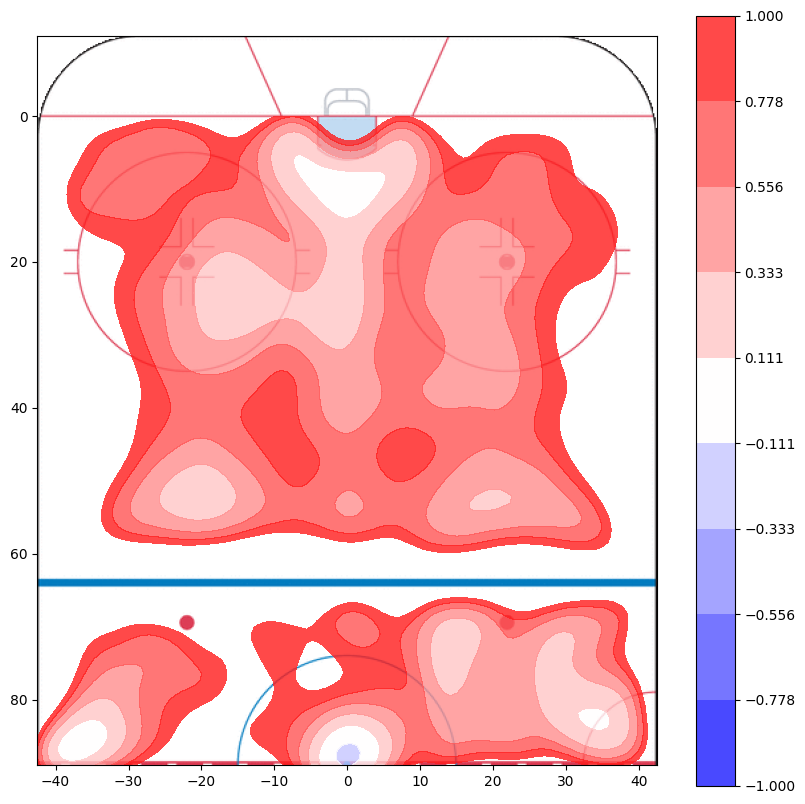

In [203]:
x_min, x_max = 0, 89
y_min, y_max = -42.5, 42.5

y_grid, x_grid = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]

fig = plt.figure(figsize=(10,10))
# plt.contourf(x_grid, y_grid, kde_diff, alpha=0.8, cmap='bwr', levels = np.linspace(kde_diff.min(), kde_diff.max(), 10), vmin=kde_diff.min(), vmax=kde_diff.max())
plt.contourf(x_grid, y_grid, kde_diff, alpha=0.8, cmap='bwr', levels = np.linspace(kde_diff_norm.min(), kde_diff_norm.max(), 10), vmin=kde_diff_norm.min(), vmax=kde_diff_norm.max())
plt.colorbar(orientation = 'vertical')
plt.imshow(rink_half_img, extent=[-42.5, 42.5, 89, -11])